In [1]:
!git clone https://github.com/matbun/EBM--Generative-Energy-Based-Modeling.git

Cloning into 'EBM--Generative-Energy-Based-Modeling'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 139 (delta 60), reused 97 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 2.73 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (60/60), done.


# Import

In [ ]:
from ebm_toy.config import *
gpu_device = "cuda:1"

set_seed(0)

In [ ]:
%load_ext autoreload
%autoreload 2

# Standard libraries
import numpy as np
from tqdm.notebook import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.tensorboard import SummaryWriter

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

# Dataset
from ebm_toy.utils import ToyDataset

print("Torch version: " + torch.__version__)

Torch version: 1.7.1


In [ ]:
device = torch.device(gpu_device) if torch.cuda.is_available() else torch.device("cpu")
print("Currenly using the device:", device)

Currenly using the device: cuda:1


# Dataset

In [ ]:
gmm_train = ToyDataset(toy_type='gmm', dataset_len=60000, viz_res=200, kde_bw=0.1)
gmm_test = ToyDataset(toy_type='gmm', dataset_len=10000, viz_res=2, kde_bw=0.1)

#rings_train = ToyDataset(toy_type='rings', dataset_len=60000, viz_res=200)
#rings_test = ToyDataset(toy_type='rings', dataset_len=10000, viz_res=2)

# Train

In [ ]:
from ebm_toy.train import EBMLangVanilla, EBMLangMomentum

# SGHMC

## Best models

In [ ]:
top_models = [
    {'C': 1, 'lr': 0.005, 'm': 2, 'mcmc_lr': 0.0005},
    {'C': 1, 'lr': 0.005, 'm': 2, 'mcmc_lr': 0.01},
    {'C': 1, 'lr': 0.01, 'm': 0.5, 'mcmc_lr': 0.01},
    {'C': 1, 'lr': 0.01, 'm': 2, 'mcmc_lr': 0.01},
    {'C': 1, 'lr': 0.01, 'm': 1, 'mcmc_lr': 0.005},
    {'C': 2, 'lr': 0.01, 'm': 0.5, 'mcmc_lr': 0.005},
    {'C': 2, 'lr': 0.01, 'm': 0.5, 'mcmc_lr': 0.01}
]

## Run 7 - no PCD; squared

In [ ]:
run_n = 7

MODEL_NAME = "lang_2_%d_noPCD_sq" % run_n
MODEL_DESCRIPTION = ""
MODEL_FAMILY = "toy_dataset"


EBMTrain = EBMLangMomentum(batch_size=100,
                           lr=top_models[run_n-1]['lr'],
                           weight_decay=0,
                           mcmc_init_type='uniform',
                           mcmc_step_size=top_models[run_n-1]['mcmc_lr'],
                           C=top_models[run_n-1]['C'],
                           mass=top_models[run_n-1]['m'],
                           mcmc_steps=500,
                           model_name=MODEL_NAME,
                           model_description=MODEL_DESCRIPTION,
                          model_family=MODEL_FAMILY,
                         device=gpu_device,
                           overwrite=True
                         )
EBMTrain.setup()
EBMTrain.prepare_data(gmm_train, gmm_test)
# Train
try:
    EBMTrain.fit(10)
finally:
    EBMTrain.clear()

Running on device: cuda:3


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

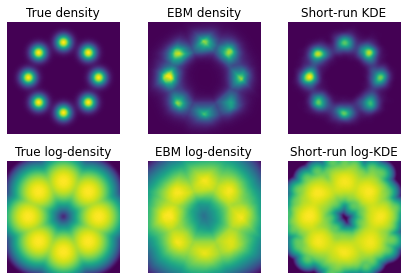

In [ ]:
negative_samples = EBMTrain.generate_samples(evaluation=True,
                                            batch_size=10000)
gmm_train.plot_toy_density(plot_truth=True,
                           f=EBMTrain.cnn,
                           x_s_t=negative_samples,
                           save_path=None)

### Assess generated samples distribution

In [ ]:
from ebm_toy.utils import ksDist

# Make sure the generation is init from rnd noise
# And the chain length is long enough
EBMTrain.mcmc_init_type = "uniform"
EBMTrain.mcmc_steps = 10000

for n_samples in [100, 1000]:
    pval, d, pval_b, d_b = ksDist(EBMTrain, gmm_train, n_samples, benchmark=True)
    print(f"# samples: {n_samples}")
    print(f"DISTANCE: {d:.2e} (ebm), {d_b:.2e} (benchmark)")
    print(f"P-VALUE ~ {pval:.2e} (ebm), {pval_b:.2e} (benchmark)")
    print()

# samples: 100
DISTANCE: 2.30e-01 (ebm), 1.50e-01 (benchmark)
P-VALUE ~ 3.51e-02 (ebm), 3.56e-01 (benchmark)

# samples: 1000
DISTANCE: 1.33e-01 (ebm), 6.65e-02 (benchmark)
P-VALUE ~ 1.28e-05 (ebm), 1.01e-01 (benchmark)



### Assess fitted density (EBM)

In [ ]:
print("Tot plot side length:", gmm_train.plot_side)
print("Single tile side length:", gmm_train.tile_side)
print("Tot tiles:", gmm_train.xy_plot.shape[0])

Tot plot side length: 3.2
Single tile side length: 0.016080402010050232
Tot tiles: 200


In [ ]:
# Discrete KL
gmm_train.ebm_kl_divergence(EBMTrain.cnn)

0.20485116451569224

## Run 7 - no PCD

In [ ]:
run_n = 7

MODEL_NAME = "lang_2_%d_noPCD" % run_n
MODEL_DESCRIPTION = ""
MODEL_FAMILY = "toy_dataset"


EBMTrain = EBMLangMomentum(batch_size=100,
                           lr=top_models[run_n-1]['lr'],
                           weight_decay=0,
                           mcmc_init_type='uniform',
                           mcmc_step_size=top_models[run_n-1]['mcmc_lr'],
                           C=top_models[run_n-1]['C'],
                           mass=top_models[run_n-1]['m'],
                           mcmc_steps=500,
                           model_name=MODEL_NAME,
                           model_description=MODEL_DESCRIPTION,
                          model_family=MODEL_FAMILY,
                         device=gpu_device,
                           overwrite=True
                         )
EBMTrain.setup()
EBMTrain.prepare_data(gmm_train, gmm_test)
# Train
try:
    EBMTrain.fit(10)
finally:
    EBMTrain.clear()

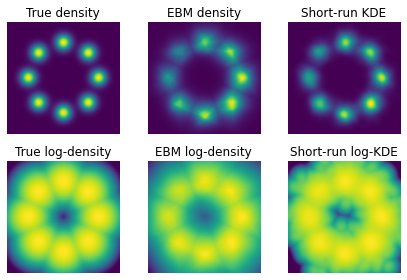

In [ ]:
negative_samples = EBMTrain.generate_samples(evaluation=True,
                                            batch_size=10000)
gmm_train.plot_toy_density(plot_truth=True,
                           f=EBMTrain.cnn,
                           x_s_t=negative_samples,
                           save_path=None)

### Assess generated samples distribution

In [ ]:
from ebm_toy.utils import ksDist

# Make sure the generation is init from rnd noise
# And the chain length is long enough
EBMTrain.mcmc_init_type = "uniform"
EBMTrain.mcmc_steps = 10000

for n_samples in [100, 1000]:
    pval, d, pval_b, d_b = ksDist(EBMTrain, gmm_train, n_samples, benchmark=True)
    print(f"# samples: {n_samples}")
    print(f"DISTANCE: {d:.2e} (ebm), {d_b:.2e} (benchmark)")
    print(f"P-VALUE ~ {pval:.2e} (ebm), {pval_b:.2e} (benchmark)")
    print()

# samples: 100
DISTANCE: 2.80e-01 (ebm), 1.45e-01 (benchmark)
P-VALUE ~ 4.94e-03 (ebm), 3.97e-01 (benchmark)

# samples: 1000
DISTANCE: 2.31e-01 (ebm), 4.25e-02 (benchmark)
P-VALUE ~ 4.25e-16 (ebm), 5.75e-01 (benchmark)



### Assess fitted density (EBM)

In [ ]:
print("Tot plot side length:", gmm_train.plot_side)
print("Single tile side length:", gmm_train.tile_side)
print("Tot tiles:", gmm_train.xy_plot.shape[0])

Tot plot side length: 3.2
Single tile side length: 0.016080402010050232
Tot tiles: 200


In [ ]:
# Discrete KL
# grid = 500 x 500
gmm_train.ebm_kl_divergence(EBMTrain.cnn)

0.29130925334996643

## Run 7 - PCD

In [ ]:
run_n = 7

MODEL_NAME = "lang_2_%d_noPCD" % run_n
MODEL_DESCRIPTION = ""
MODEL_FAMILY = "toy_dataset"


EBMTrain = EBMLangMomentum(batch_size=100,
                           lr=top_models[run_n-1]['lr'],
                           weight_decay=0,
                           mcmc_step_size=top_models[run_n-1]['mcmc_lr'],
                           C=top_models[run_n-1]['C'],
                           mass=top_models[run_n-1]['m'],
                           mcmc_steps=500,
                           model_name=MODEL_NAME,
                           model_description=MODEL_DESCRIPTION,
                          model_family=MODEL_FAMILY,
                         device=gpu_device
                         )
EBMTrain.setup()
EBMTrain.prepare_data(gmm_train, gmm_test)

Running on device: cuda:3


In [ ]:
# Train
try:
    EBMTrain.fit(10)
finally:
    EBMTrain.clear()

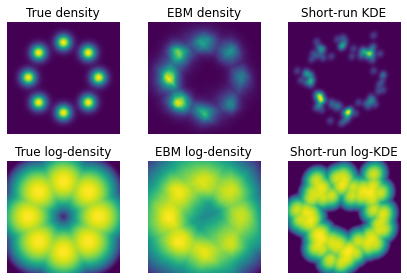

In [ ]:
negative_samples = EBMTrain.generate_samples(evaluation=True)
gmm_train.plot_toy_density(plot_truth=True,
                           f=EBMTrain.cnn,
                           x_s_t=negative_samples,
                           save_path=None)

### Assess generated samples distribution

In [ ]:
from ebm_toy.utils import ksDist

# Make sure the generation is init from rnd noise
# And the chain length is long enough
EBMTrain.mcmc_init_type = "uniform"
EBMTrain.mcmc_steps = 10000

for n_samples in [100, 1000]:
    pval, d, pval_b, d_b = ksDist(EBMTrain, gmm_train, n_samples, benchmark=True)
    print(f"# samples: {n_samples}")
    print(f"DISTANCE: {d:.2e} (ebm), {d_b:.2e} (benchmark)")
    print(f"P-VALUE ~ {pval:.2e} (ebm), {pval_b:.2e} (benchmark)")
    print()

# samples: 100
DISTANCE: 3.95e-01 (ebm), 1.50e-01 (benchmark)
P-VALUE ~ 1.33e-05 (ebm), 3.56e-01 (benchmark)

# samples: 1000
DISTANCE: 2.98e-01 (ebm), 6.65e-02 (benchmark)
P-VALUE ~ 1.71e-26 (ebm), 1.01e-01 (benchmark)



### Assess fitted density (EBM)

In [ ]:
print("Tot plot side length:", gmm_train.plot_side)
print("Single tile side length:", gmm_train.tile_side)
print("Tot tiles:", gmm_train.xy_plot.shape[0])

Tot plot side length: 3.2
Single tile side length: 0.016080402010050232
Tot tiles: 200


In [ ]:
# Discrete KL
# grid = 500 x 500
gmm_train.ebm_kl_divergence(EBMTrain.cnn)

0.2644902493887782